# Data collection:

In [7]:
%%time
import glob
import joblib
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import altair as alt
from collections import Counter
import re
import json
pd.set_option('display.max_colwidth', None)

RANDOM_STATE = 42

extracted_data = joblib.load("../data/ru_wiki_extracted_pages.data")
error_data = joblib.load("../data/ru_wiki_error_pages.data")
final_data = pd.DataFrame(joblib.load("../data/ru_wiki_final_dataset_v2.data"))
with open('../data/ru_reveal_wiki_location.json') as user_file:
    ru_reveal_wiki_location = json.load(user_file)
locations_dict = dict()
for location in tqdm(ru_reveal_wiki_location):
    location_key = list(location.keys())[0]
    location_values = np.sort(list(location.values())[0])
    locations_dict[location_key] = "_".join(location_values)

with open('../data/ru_reveal_wiki_topic.json') as user_file:
    ru_reveal_wiki_topic = json.load(user_file)
topics_dict = {list(d.keys())[0]: [v['topic'] for v in list(d.values())[0]] for d in tqdm(ru_reveal_wiki_topic)}

# Processing data: 
changed_df = final_data[final_data.status.isin([3, 4])]
action_features = pd.DataFrame(changed_df["actions"].to_list())
status_features = changed_df[["status"]].reset_index(drop=True)
n_added = changed_df.lines_added.apply(len).reset_index(drop=True)
n_removed = changed_df.lines_deleted.apply(len).reset_index(drop=True)
n_changed = changed_df.lines_changed.apply(len).reset_index(drop=True)

# Category
categories_added, categories_removed = [], []
categories_counter = Counter()
for wiki_features, ruwiki_features in \
    zip(changed_df["wiki_features"].to_list(), changed_df["ruwiki_features"].to_list()):
    categories_added.append(set(ruwiki_features["categories"]) - set(wiki_features["categories"]))
    categories_removed.append(set(wiki_features["categories"]) - set(ruwiki_features["categories"])) 
    categories_counter.update(categories_added[-1])
    categories_counter.update(categories_removed[-1])
    
# topic
topics = changed_df.page_name.apply(lambda d: list(np.sort(topics_dict.get(d, [])))).values
# location
locations = changed_df.page_name.apply(lambda d: locations_dict.get(d, "unknown")).values

100%|██████████| 1924975/1924975 [00:33<00:00, 58075.49it/s] 


CPU times: user 1min 45s, sys: 1min 51s, total: 3min 37s
Wall time: 4min 27s


In [ ]:
from itertools import product
from fuzzywuzzy import fuzz  # type: ignore

def clean_text(text):
    if text is None:
        return text
    # Remove \n characters
    text = re.sub(r'\n', ' ', text)
    # Remove redundant spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_template(text):
    return text

def get_template_parameters(templates):
    all_parameters = {}
    for t in templates:
        # Split the template string on the '|' character
        parts = t.split('|')

        if parts:
            # The first part is assumed to be the template name
            template_name = parts[0]

            # Initialize a dictionary for the current template
            template_parameters = {}

            # Process the remaining parts as parameter key-value pairs
            for param_pair in parts[1:]:
                param_split = param_pair.split('=')
                param_name, param_value = param_split[0], "".join(param_split[1:])
                # Create a combined key using the template name and parameter name
                combined_key = f"{template_name}+{param_name}"
                template_parameters[clean_text(combined_key)] = clean_text(param_value)

            # Add the template name and its parameters to the dictionary
            all_parameters.update(template_parameters)

    return all_parameters


def compare_templates(t1, t2): 
    params1 = get_template_parameters([t1])
    params2 = get_template_parameters([t2])
    changes = []
    for i in params1.keys():
        if params2.get(i) != params1.get(i):
            param_to_add = (i, params1.get(i), params2.get(i))
            if param_to_add not in changes:
                changes.append(param_to_add)
                
    for i in params2.keys():
        if params2.get(i) != params1.get(i):
            param_to_add = (i, params1.get(i), params2.get(i))
            if param_to_add not in changes:
                changes.append(param_to_add)
    
    return changes

In [9]:
# Templates
error_count = 0
tem_added, tem_deleted, param_change = [], [], []
tem_added_counter, tem_deleted_counter, param_change_counter = Counter(), Counter(), Counter()
for wiki_features, ruwiki_features in \
    tqdm(zip(changed_df["wiki_features"].to_list(), changed_df["ruwiki_features"].to_list())):
    tem_added.append(set([clean_template(i) for i in ruwiki_features["templates"]]) - set([clean_template(i) for i in wiki_features["templates"]]) - set([None]))
    tem_deleted.append(set([clean_template(i) for i in wiki_features["templates"]]) - set([clean_template(i) for i in ruwiki_features["templates"]]) - set([None]))
    tem_added_counter.update(tem_added[-1])
    tem_deleted_counter.update(tem_deleted[-1])
    
    params_changed = []
    
    tem_added_tmp = set(ruwiki_features["templates"]) - set(wiki_features["templates"]) - set([None])
    tem_deleted_tmp = set(wiki_features["templates"]) - set(ruwiki_features["templates"]) - set([None])
    for t1, t2 in product(tem_added_tmp, tem_deleted_tmp):
        similarity = fuzz.ratio(t1, t2)
        if similarity > 60 and similarity < 100:
            try:
                # remove similar templates from the list (as canges will be added to the list)
                tem_added[-1] = tem_added[-1] - set([t1])
                tem_deleted[-1] = tem_deleted[-1] - set([t2])
                params_changed += compare_templates(t1, t2)
            except Exception as e:
                print(e)
                error_count += 1
                pass
    param_change.append(params_changed)
    param_change_counter.update(params_changed)

33664it [03:13, 174.21it/s]


# Creating a collective text:

In [10]:
MAX_SYMBOLS = int(8000 * 1.5)
MAX_TEMPLATES = 3

# Define template for page information encoding in text: 
pages_collective_strings = []
is_not_change = []
for i, (_, row) in enumerate(changed_df.iterrows()):
    is_change = False
    page_string = ""
    page_title = row.page_name
    page_string += f"page title: {page_title}\n"
    change_type = "metadata change" if row.status == 3 else "text change"
    page_string += f"change type: {change_type}\n"

    lines_added = " ".join(row.lines_added)
    if len(lines_added) > 0:
        page_string += f"lines added: {lines_added}\n"
        is_change = True
    lines_removed = " ".join(row.lines_deleted)
    if len(lines_removed) > 0:
        page_string += f"lines removed: {lines_removed}\n"
        is_change = True
    lines_changed = "\n".join([f"Old value: {c[0]}\nNew value: {c[1]}\n" for c in row.lines_changed])
    if len(lines_changed) > 0:
        page_string += f"lines changed: : {lines_changed}\n"
        is_change = True
    categories_a = ", ".join(categories_added[i])
    if len(categories_a) > 0:
        page_string += f"categories added: {categories_a}\n"
        is_change = True
    categories_r = ", ".join(categories_removed[i])
    if len(categories_r) > 0:
        page_string += f"categories removed: {categories_r}\n"
        is_change = True
    page_location = locations[i]
    page_string += f"page location: {page_location}\n"
    page_t = ", ".join(topics[i][:MAX_TEMPLATES])
    page_string += f"page topics: {page_t}\n"
    template_changes = "\n".join([f"Template: {c[0]}\nOld value: {c[2]}\nNew value: {c[1]}\n" for c in param_change[i]])
    if len(template_changes) > 0:
        page_string += f"template changes: {template_changes}\n"
        is_change = True
    templates_added = ", ".join(list(tem_added[i])[:MAX_TEMPLATES])
    if len(templates_added) > 0:
        page_string += f"templates added: {templates_added}\n"
        is_change = True
    templates_removed = ", ".join(list(tem_deleted[i])[:MAX_TEMPLATES])
    if len(templates_removed) > 0:
        page_string += f"templates removed: {templates_removed}\n"
        is_change = True

    pages_collective_strings.append(page_string[:MAX_SYMBOLS])
    is_not_change.append(is_change)

In [11]:
import tiktoken
texts_to_embed = [t for t, c in zip(pages_collective_strings, is_not_change) if c]
len(texts_to_embed)

# Calculate number of tokent in each text
tokenizer = tiktoken.get_encoding("cl100k_base")
token_lens = [len(tokenizer.encode(text)) for text in texts_to_embed]

In [252]:
i = 100
print("Len", token_lens[i])
print("len", len(texts_to_embed[i]))
print(texts_to_embed[i])

Len 90
len 276
page title: Палецкий, Василий Дмитриевич
change type: metadata change
categories removed: Статьи с эдитнотисом об осторожности при редактировании
page location: unknown
page topics: Culture.Biography.Biography*, Geography.Regions.Asia.Asia*, Geography.Regions.Asia.North_Asia



In [254]:
assert max(token_lens) < 8000

# Proposed scope: 

1. Pipeline for defining the taxonomy of changes:
    - 1.1 Summarisation of edits
    - 1.2 Embedding of texts
    - 1.3 Clustering of summarised texts -> best silhoutte score
    - 1.4 Automatic name for clusters

2. Define the quality of clustring in zero-shot classification of the sample.
    - Sample 20% of cluster and classify them with zero-shot classification.
    - Define the rate of correctly classified samples.
    - Define the confidence interval for the classification.

# 1. Pipeline for defining the taxonomy of changes:

## 1.1 Summarisation of edits

In [200]:
import pandas as pd
import json

jsonl_file = "../data/embed/input/batch_requests_summary_"
jsonl_resp_file = "../data/embed/output/batch_responses_summary_"
model_name = 'gpt-4o-mini-2024-07-18'
max_batch_size = 4000
max_summary_words = 40
jsonl_files = []

initial_prompt = f"""
    You will be provided with a details regarding edit to the Wikipedia page.
    You need to deeply analyse the changes, define what was edited and provide a description of the changes.

    Provide a short summary and specific factual changes. 
    Pay attention to details about adding/removing/changing characteristics.
    Avoid generalizations and provide specific examples.  (max {max_summary_words} words)

    Return the answer in JSON format with only "desc" field and the following structure:
    {{
        "desc": "string"  # description of specific factual changes
    }}

    The edit to analize will be provided in the <>:
    """

for i in range(0, len(texts_to_embed), max_batch_size):
    with open(jsonl_file + f"_{i}.jsonl", "w") as f:
        for j, claim in enumerate(texts_to_embed[i:i+max_batch_size]):
            request = {
                "custom_id": f"r-{i}-{j}",
                "method": "POST",
                "url": "/v1/chat/completions",
                "body": {
                    "model": model_name,
                    "messages": [
                        {"role": "system", "content": initial_prompt},
                        {"role": "user", "content": f"<{claim}>"},
                    ],
                "max_tokens": max_summary_words * 10
                }
            }
            f.write(json.dumps(request) + "\n")
    jsonl_files.append(jsonl_file + f"_{i}.jsonl")
    print(len(texts_to_embed[i:i+max_batch_size]))

4000
4000
4000
4000
4000
4000
4000
2599


In [201]:
from dotenv import load_dotenv
from openai import OpenAI

load_dotenv()
client = OpenAI()

batch_input_files = []
for jsonl_file in jsonl_files:
  batch_input_file = client.files.create(
    file=open(jsonl_file, "rb"),
    purpose="batch"
  )
  batch_input_files.append(batch_input_file)

In [256]:
batch_input_file_ids = []

i = 7

for batch_input_file in batch_input_files[i:i+1]:
  batch_input_file_id = batch_input_file.id
  client.batches.create(
      input_file_id=batch_input_file_id,
      endpoint="/v1/chat/completions",
      completion_window="24h",
      metadata={
        "description": "summarisation for ruwiki"
      }
  )
  batch_input_file_ids.append(batch_input_file_id)

In [325]:
# batches = client.batches.list(limit=10)
# batches.data

In [302]:
# Get all file names:
import glob
from tqdm.auto import tqdm


def parse_json(text):
    text = text.replace('"desc": " ', '"desc": "')
    text = text.replace("\'Донецкой области\' на \'Донецкой Народной Республике\'", "Донецкой области на Донецкой Народной Республике")
    text = text.replace('"Радивоновка"', 'Радивоновка').replace('"Акимовском районе"', 'Акимовском районе').replace('"Мелитополе"', 'Мелитополе')
    text = text.replace('```json\n', '').replace('\n```', '').replace(',\n}', '}').replace('" "', ' empty double quotes ')
    text = text.replace('\"буржуек\"', '\\\"буржуек\\\"').replace(' " ', ' double quotes  ').replace("”", '"')
    text = text.replace('"будут изображены" to "изображены"', 'будут изображены to изображены')
    text = text.replace('55°47\'32"N 37°36\'15"E.', "").replace("\\\'Маньяк\\\'", "Маньяк").replace(")\n}", "\n}")
    text = text.replace('"нерешительное и дилетантское"', 'нерешительное и дилетантское')
    
    return json.loads(text)
    # except Exception as e:
    #     print(e)
    #     return None

files = glob.glob("../data/embed/output/summary/batch_*.jsonl")
responses = []
for output_file in files:
    # Read responses from jsonl file
    with open(output_file, "r") as f:
        for line in f:
            responses.append(json.loads(line))

summaries = []
ids = []
for response in tqdm(responses):
    summaries.append(parse_json(response["response"]["body"]["choices"][0]['message']["content"]))
    ids.append(response["custom_id"])

summary_dict = dict(zip(ids, summaries))

# Extracting requests and their ids:
jsonl_files_input = glob.glob("../data/embed/input/batch_requests_summary*.jsonl")

ids_input = []
texts_input = []
for file in jsonl_files_input:
    with open(file, "r") as f:
        for line in f:
            request = json.loads(line)
            ids_input.append(request["custom_id"])
            texts_input.append(request["body"]["messages"][1]["content"][1:-1])

# Create a dataframe with the embeddings and the ids
text_to_summary = {text: summary_dict.get(id, None)['desc'] for text, id in zip(texts_input, ids_input) if summary_dict.get(id, None) is not None}

100%|██████████| 30599/30599 [00:00<00:00, 132247.98it/s]


## 1.2 Embedding of texts

In [307]:
summary_texts = list(text_to_summary.values())

jsonl_file = "../data/embed/input/batch_requests_embed_summary"
model_name = "text-embedding-3-small"
max_batch_size = 11000
jsonl_files = []

for i in range(0, len(summary_texts), max_batch_size):
    with open(jsonl_file + f"_{i}.jsonl", "w") as f:
        for j, claim in enumerate(summary_texts[i:i+max_batch_size]):
            request = {
                "custom_id": f"r-{i}-{j}",
                "method": "POST",
                "url": "/v1/embeddings",
                "body": {
                    "model": model_name,
                    "input": claim,
                }
            }
            f.write(json.dumps(request) + "\n")
    jsonl_files.append(jsonl_file + f"_{i}.jsonl")
    print(len(summary_texts[i:i+max_batch_size]))

11000
11000
8599


In [308]:
from dotenv import load_dotenv
from openai import OpenAI

load_dotenv()
client = OpenAI()

batch_input_files = []
for jsonl_file in jsonl_files:
  batch_input_file = client.files.create(
    file=open(jsonl_file, "rb"),
    purpose="batch"
  )
  batch_input_files.append(batch_input_file)

In [309]:
batch_input_file_ids = []

for batch_input_file in batch_input_files:
  batch_input_file_id = batch_input_file.id
  client.batches.create(
      input_file_id=batch_input_file_id,
      endpoint="/v1/embeddings",
      completion_window="24h",
      metadata={
        "description": "embeddings for ruwiki"
      }
  )
  batch_input_file_ids.append(batch_input_file_id)

In [312]:
# batches = client.batches.list(limit=10)
# batches.data

In [313]:
# Get all file names:
import glob

files = glob.glob("../data/embed/output/embedding_summary/batch_*.jsonl")
responses = []
for output_file in files:
    # Read responses from jsonl file
    with open(output_file, "r") as f:
        for line in f:
            responses.append(json.loads(line))

embeddings = []
ids = []
for response in responses:
    embeddings.append(response["response"]["body"]["data"][0]['embedding'])
    ids.append(response["custom_id"])

embeddings_dict = dict(zip(ids, embeddings))

In [319]:
# Extracting requests and their ids:
jsonl_files_input = glob.glob("../data/embed/input/batch_requests_embed*.jsonl")

ids_input = []
texts_input = []
for file in jsonl_files_input:
    with open(file, "r") as f:
        for line in f:
            request = json.loads(line)
            ids_input.append(request["custom_id"])
            texts_input.append(request["body"]["input"])

# Create a dataframe with the embeddings and the ids
text_to_embedding = {text: embeddings_dict[id] for text, id in zip(texts_input, ids_input)}

In [327]:
import joblib
joblib.dump(text_to_embedding, "../data/embed/summary_text_to_embedding.bin")
# text_to_embedding = joblib.load("../data/embed/summary_text_to_embedding_full.bin")

['../data/embed/summary_text_to_embedding.bin']

## 1.3 Clustering of summarised texts:

  7%|▋         | 1/14 [00:35<07:42, 35.56s/it]

Silhouette score for 2 clusters: 0.08063241301780896


 14%|█▍        | 2/14 [01:07<06:40, 33.40s/it]

Silhouette score for 3 clusters: 0.07736409975627694


 21%|██▏       | 3/14 [01:40<06:05, 33.21s/it]

Silhouette score for 4 clusters: 0.06778208467628967


 29%|██▊       | 4/14 [02:11<05:25, 32.56s/it]

Silhouette score for 5 clusters: 0.08351021968169993


 36%|███▌      | 5/14 [02:44<04:52, 32.47s/it]

Silhouette score for 6 clusters: 0.08691509031389795


 43%|████▎     | 6/14 [03:16<04:20, 32.51s/it]

Silhouette score for 7 clusters: 0.08231027656766764


 50%|█████     | 7/14 [03:49<03:47, 32.45s/it]

Silhouette score for 8 clusters: 0.1054651574772751


 57%|█████▋    | 8/14 [04:20<03:12, 32.03s/it]

Silhouette score for 9 clusters: 0.09988225820947819


 64%|██████▍   | 9/14 [04:55<02:45, 33.08s/it]

Silhouette score for 10 clusters: 0.09949659457031808


 71%|███████▏  | 10/14 [05:28<02:11, 32.95s/it]

Silhouette score for 11 clusters: 0.10016089374842385


 79%|███████▊  | 11/14 [06:03<01:40, 33.64s/it]

Silhouette score for 12 clusters: 0.09198641480370513


 86%|████████▌ | 12/14 [06:34<01:05, 32.88s/it]

Silhouette score for 13 clusters: 0.0945400211772505


 93%|█████████▎| 13/14 [07:05<00:32, 32.13s/it]

Silhouette score for 14 clusters: 0.0938919426331382


100%|██████████| 14/14 [07:37<00:00, 32.65s/it]

Silhouette score for 15 clusters: 0.06560383808967979


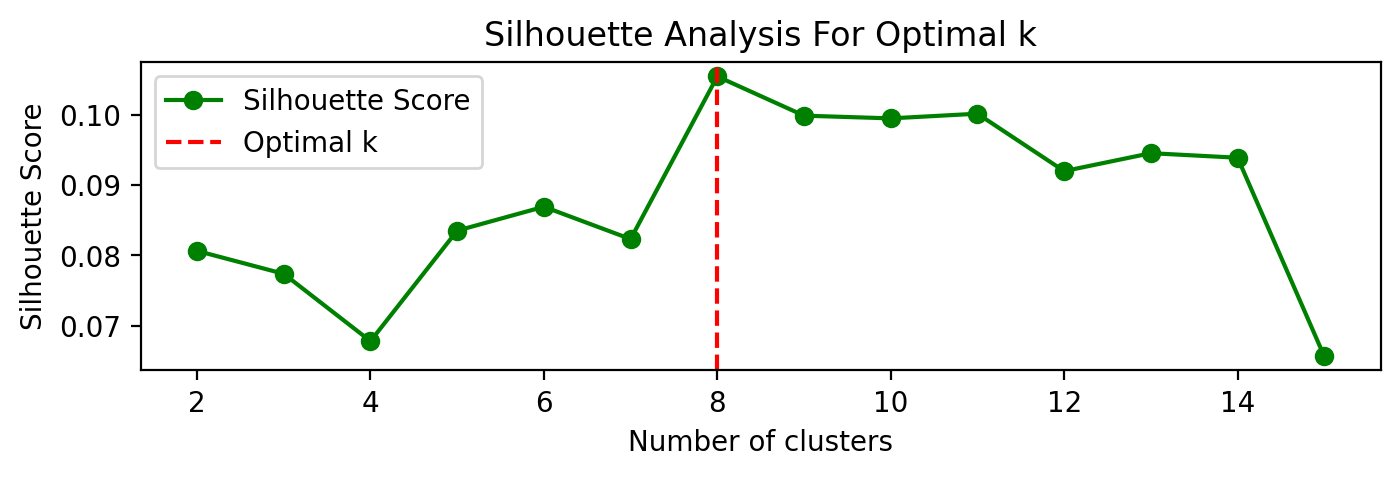

In [745]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

# embeddings = [text_to_embedding[t] for t in summary_texts]

silhouette_scores = []
K = range(2, 16)
for k in tqdm(K):
    km = KMeans(n_clusters=k, init="k-means++", random_state=RANDOM_STATE)
    km = km.fit(embeddings)
    labels = km.labels_
    silhouette_scores.append(silhouette_score(embeddings, labels))
    print(f"Silhouette score for {k} clusters: {silhouette_scores[-1]}")

# Increase the resolution and adjust figure size
plt.figure(dpi=200, figsize=(8, 2))  # Twice the default resolution, half the default height
# Plot with a new color
plt.plot(K, silhouette_scores, 'go-', label='Silhouette Score')

# Add xlabel, ylabel, and title
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')

# Find the number of clusters with the maximum silhouette score
max_score_index = silhouette_scores.index(max(silhouette_scores))
optimal_k = K[max_score_index]

# Add a vertical line at the maximum silhouette score
plt.axvline(x=optimal_k, color='r', linestyle='--', label='Optimal k')
# Add a legend
plt.legend()
plt.show()



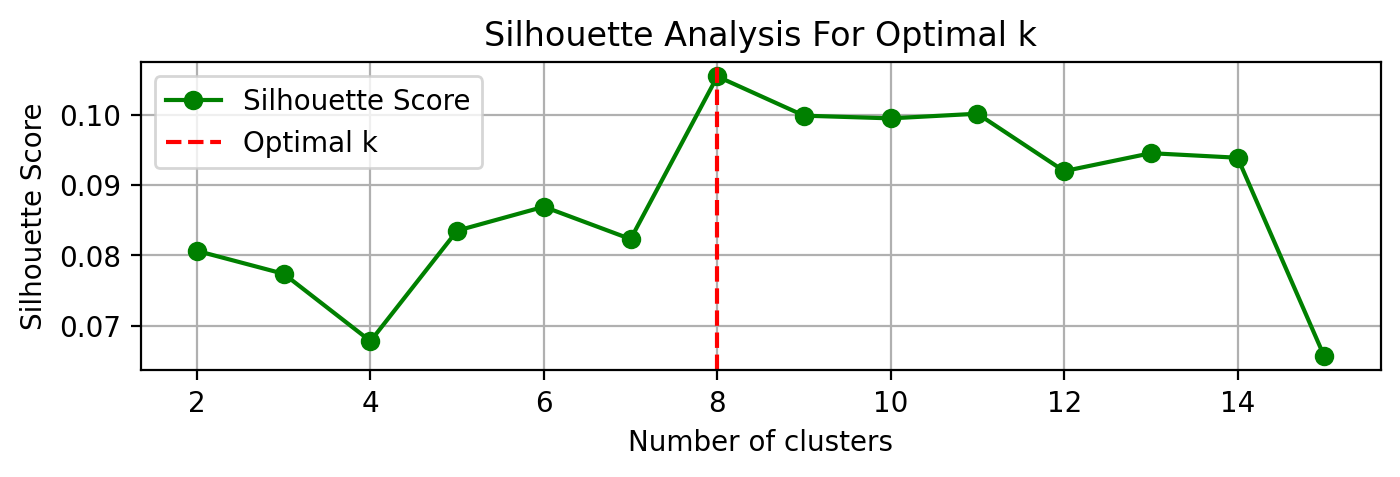

In [966]:
# Save the plot:

# Increase the resolution and adjust figure size
plt.figure(dpi=200, figsize=(8, 2))  # Twice the default resolution, half the default height
# Plot with a new color
plt.plot(K, silhouette_scores, 'go-', label='Silhouette Score')

# Add xlabel, ylabel, and title
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')

# Find the number of clusters with the maximum silhouette score
max_score_index = silhouette_scores.index(max(silhouette_scores))
optimal_k = K[max_score_index]

# Add a vertical line at the maximum silhouette score
plt.axvline(x=optimal_k, color='r', linestyle='--', label='Optimal k')
# Add a legend
plt.legend()
plt.grid()
# plt.show()

plt.savefig("../data/embed/summary_silhouette_score.png", dpi=300)

In [746]:
km = KMeans(n_clusters=optimal_k, init="k-means++", random_state=RANDOM_STATE)
km = km.fit(embeddings)
labels = km.labels_

In [747]:
clusters_df = pd.DataFrame({
    "text": list(summary_texts),
    "label": labels,
})
clusters_df["label"].value_counts()

1    7753
7    5063
6    3846
0    3786
2    3139
3    2709
4    2678
5    1625
Name: label, dtype: int64

## 1.4 Automatic name for clusters:

In [822]:
# Defining the cluster name
from langchain.chat_models import ChatOpenAI
import os
import json
# Build a vector for cluster by name and description
from openai import OpenAI

# embedding model parameters
embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
gpt = ChatOpenAI(model='gpt-4o-mini-2024-07-18', temperature=0, openai_api_key=os.environ['OPENAI_API_KEY'])

client = OpenAI()

def get_cluster_details(text_examples, gpt=gpt):
    examples_string = "\n".join(f"Summary {i+1}: {text}" for i, text in enumerate(text_examples))
    prompt = """
    You are provided with a sample list of edits for one cluster. Your task is to describe these edits.

    1. Identify the common theme or topic shared by the edits.
    2. Summarize the main changes made in these edits, including examples of editing tactics used, avoiding specific details.

    You need to:
    - Provide a descriptive name for the cluster, representing the topic and idea of the edits (maximum 4 words).
    - Add a concise summary of the changes within the cluster (maximum 40 words).

    Return the answer in JSON format with the following structure:
    {
        "cluster_name": "name",
        "cluster_summary": "summary"
    }

    The list of changes is provided below:
    """ + examples_string
    
    res = gpt.invoke(prompt).content

    return json.loads(res.replace('```json\n', '').replace('\n```', ''))


def get_embedding(text, model=embedding_model):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding
# cluster_emb = get_embedding(json.dumps(cluster_details), model=embedding_model)

In [850]:
SAMPLE_SIZE = 20

cluster_details = []
for i in tqdm(range(clusters_df.label.nunique())):
    text_examples = clusters_df[clusters_df.label == i].sample(SAMPLE_SIZE, random_state=RANDOM_STATE).text.tolist()
    llm_result = get_cluster_details(text_examples)
    cluster_details.append(llm_result)

# cluster_details = joblib.load("../data/embed/cluster_details.bin")
joblib.dump(cluster_details, "../data/embed/cluster_details.bin")

100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


['../data/embed/cluster_details.bin']

In [851]:
tmp = pd.DataFrame(cluster_details)
tmp

,cluster_name,cluster_summary
0,LGBT Rights and History,"The edits focus on updating and clarifying information related to LGBT rights, historical events, and notable figures, while removing outdated or derogatory content."
1,Territorial Claims Dispute,"Edits reflect changes in territorial designations and governance, emphasizing claims by the Donetsk and Luhansk People's Republics while removing Ukrainian references and administrative details."
2,Editing Caution Removal,"Multiple Wikipedia pages had the editing caution category removed, indicating a change in the perceived necessity for careful editing."
3,Terminology Changes Ukraine,"Edits focus on altering terminology related to the Russia-Ukraine conflict, shifting from specific invasion references to broader military actions and general policies."
4,Cultural Metadata Updates,"Edits focused on updating metadata with locations, cultural topics, and adding age and gender templates for various pages."
5,Russian Legislation Medicines,"Templates for Russian legislation and medications were added to various pharmaceutical pages, enhancing their categorization and relevance."
6,Sanctions Edit Adjustments,"The edits focus on removing specific references to the Ukraine conflict in sanctions descriptions, simplifying statements, and altering context around individuals and entities sanctioned."
7,Metadata Updates,"Various edits focused on updating metadata templates, removing outdated references, and refining geographical classifications across multiple Wikipedia pages."


# 2. Define the quality of clustring in zero-shot classification + reclassification all the texts:
    - Define the number of correctly classified examples.
        - Reclassify if needed. 
    - Define the rate of correctly classified samples.
    - Define the confidence interval for the classification.

# 2.1 Defining clustering fit: 

In [856]:
jsonl_file = "../data/embed/input/batch_requests_zero_shot_fit"
model_name = 'gpt-4o-mini-2024-07-18'
max_batch_size = 6500
jsonl_files = []

initial_prompt = """
    You are provided with a specific edit to the Wikipedia page (defined in <>) along with possible cluster details (defined in {}) to which the edit belongs.
    You need to analyse the edit and decide whether the edit fits the provided cluster or not.
    Provide ONLY a short answer (YES or NO).
"""

texts_to_classify = clusters_df["text"].values
cluster_details_all = clusters_df["label"].values

for i in range(0, len(texts_to_classify), max_batch_size):
    texts_to_classify_batch = texts_to_classify[i:i+max_batch_size]
    cluster_details_batch = cluster_details_all[i:i+max_batch_size]
    with open(jsonl_file + f"_{i}.jsonl", "w") as f:
        for j, (text_example, cluster_details_i) in enumerate(zip(texts_to_classify_batch, cluster_details_batch)):
            request = {
                "custom_id": f"{i}-{j}",
                "method": "POST",
                "url": "/v1/chat/completions",
                "body": {
                    "model": model_name,
                    "messages": [
                        {"role": "system", "content": initial_prompt},
                        {"role": "user", "content": f"Edit summary: <{text_example}>"},
                        {"role": "user", "content": f"Cluster details: {cluster_details[cluster_details_i]}"},
                    ],
                "max_tokens": 5
                }
            }
            f.write(json.dumps(request) + "\n")

    jsonl_files.append(jsonl_file + f"_{i}.jsonl")

In [857]:
from dotenv import load_dotenv
from openai import OpenAI

load_dotenv()
client = OpenAI()

batch_input_files = []
for jsonl_file in jsonl_files:
  batch_input_file = client.files.create(
    file=open(jsonl_file, "rb"),
    purpose="batch"
  )
  batch_input_files.append(batch_input_file)

In [885]:
a = 4

for batch_input_file in batch_input_files[a:a+1]:
  batch_input_file_id = batch_input_file.id
  client.batches.create(
      input_file_id=batch_input_file_id,
      endpoint="/v1/chat/completions",
      completion_window="24h",
      metadata={
        "description": "zero-shot for ruwiki"
      }
  )
  batch_input_file_ids.append(batch_input_file_id)

In [904]:
# Get all file names:
import glob
from tqdm.auto import tqdm


def parse_text(text):
    text = text.lower()
    if text == "yes":
        return 1
    else:
        return 0

files = glob.glob("../data/embed/output/zero_shot_fit/batch_*.jsonl")
responses = []
for output_file in files:
    # Read responses from jsonl file
    with open(output_file, "r") as f:
        for line in f:
            responses.append(json.loads(line))

responses_binary = []
sample_ids = []
for response in tqdm(responses):
    responses_binary.append(parse_text(response["response"]["body"]["choices"][0]['message']["content"]))
    sample_ids.append(response["custom_id"])

zero_shot_dict = dict(zip(sample_ids, responses_binary))

# Extracting requests and their ids:
jsonl_files_input = glob.glob("../data/embed/input/batch_requests_zero*.jsonl")

ids_input = []
texts_input = []
for file in jsonl_files_input:
    with open(file, "r") as f:
        for line in f:
            request = json.loads(line)
            ids_input.append(request["custom_id"])
            texts_input.append(request["body"]["messages"][1]["content"][15:-1])

text_input_to_id = dict(zip(texts_input, ids_input))
text_to_zero_shot = {text: zero_shot_dict[idd] for text, idd in text_input_to_id.items()}
results = [text_to_zero_shot.get(text) for text in clusters_df["text"].values]

assert len(clusters_df) == len(results)
clusters_df["is_correct"] = results

100%|██████████| 30599/30599 [00:00<00:00, 1139162.88it/s]


In [907]:
# Calculate the accuracy
clusters_df.groupby("label").is_correct.mean()

label
0    0.016112
1    0.875661
2    0.998726
3    0.972684
4    0.995892
5    0.999385
6    0.594124
7    0.928501
Name: is_correct, dtype: float64

In [973]:
def draw_bs_replicates(data, func, size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data, size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    return bs_replicates

medians = []
deltas = []
counts = []
for i in range(clusters_df.label.nunique()):
    cluster_results = clusters_df[clusters_df.label == i].is_correct.values
    bs_stats = draw_bs_replicates(
        cluster_results, np.mean, 1000
    )
    medians.append(np.median(bs_stats) * 100)
    deltas.append(np.std(bs_stats) * 2 * 100)
    counts.append(len(cluster_results))

results_df = pd.DataFrame({
    "cluster_id": range(clusters_df.label.nunique()),
    "median": medians,
    "delta": deltas,
    "count": counts
})
results_df

,cluster_id,median,delta,count
0,0,1.611199,0.407866,3786
1,1,87.566103,0.750343,7753
2,2,99.872571,0.129668,3139
3,3,97.268365,0.649320,2709
4,4,99.589246,0.242295,2678
5,5,99.938462,0.119887,1625
6,6,59.386375,1.576484,3846
7,7,92.850089,0.725048,5063


# 2.2 Zero-shot reclassification:

In [915]:
clusters_df["id"] = np.arange(len(clusters_df))
clusters_df_incorrect = clusters_df[clusters_df.is_correct == False]
print(len(clusters_df_incorrect))

6702


In [922]:
jsonl_file = "../data/embed/input/batch_requests_zero_shot_reclass"
model_name = 'gpt-4o-mini-2024-07-18'
max_batch_size = 3500
jsonl_files = []

cluster_details_str = '\n'.join([f"{i}. {c['cluster_name']}: {c['cluster_summary']}" for i, c in enumerate(cluster_details)])

initial_prompt = f"""
    You are provided with a specific edit to the Wikipedia page (defined in <>).

    You need to reclassify the edit to the correct cluster based on the provided cluster details.

    Cluster details:
    {cluster_details_str}
    8. Other changes: The edit does not fit any of the provided clusters. (always use this option if the edit does not fit any of the provided clusters)

    Provide ONLY a short answer (cluster number). (0-{len(cluster_details)})
"""

texts_to_classify = clusters_df_incorrect["text"].values
texts_ids = clusters_df_incorrect["id"].values

for i in range(0, len(texts_to_classify), max_batch_size):
    texts_to_classify_batch = texts_to_classify[i:i+max_batch_size]
    texts_ids_batch = texts_ids[i:i+max_batch_size]
    with open(jsonl_file + f"_{i}.jsonl", "w") as f:
        for j, (text_example, idd) in enumerate(zip(texts_to_classify_batch, texts_ids_batch)):
            request = {
                "custom_id": f"{idd}",
                "method": "POST",
                "url": "/v1/chat/completions",
                "body": {
                    "model": model_name,
                    "messages": [
                        {"role": "system", "content": initial_prompt},
                        {"role": "user", "content": f"Edit summary to classify: <{text_example}>"},
                    ],
                "max_tokens": 5
                }
            }
            f.write(json.dumps(request) + "\n")
    jsonl_files.append(jsonl_file + f"_{i}.jsonl")

In [923]:
from dotenv import load_dotenv
from openai import OpenAI

load_dotenv()
client = OpenAI()

batch_input_files = []
for jsonl_file in jsonl_files:
  batch_input_file = client.files.create(
    file=open(jsonl_file, "rb"),
    purpose="batch"
  )
  batch_input_files.append(batch_input_file)

In [925]:
for batch_input_file in batch_input_files[1:]:
  batch_input_file_id = batch_input_file.id
  client.batches.create(
      input_file_id=batch_input_file_id,
      endpoint="/v1/chat/completions",
      completion_window="24h",
      metadata={
        "description": "zero-shot reclass for ruwiki"
      }
  )
  batch_input_file_ids.append(batch_input_file_id)

In [930]:
files = glob.glob("../data/embed/output/zero_shot_reclass/batch_*.jsonl")
responses = []
for output_file in files:
    # Read responses from jsonl file
    with open(output_file, "r") as f:
        for line in f:
            responses.append(json.loads(line))

responses_binary = []
sample_ids = []
for response in tqdm(responses):
    responses_binary.append(int(float(response["response"]["body"]["choices"][0]['message']["content"])))
    sample_ids.append(response["custom_id"])

zero_shot_reclass_dict = dict(zip(sample_ids, responses_binary))

100%|██████████| 6702/6702 [00:00<00:00, 907747.78it/s]


In [934]:
new_cluster_ids = []
for idd, label in zip(clusters_df["id"].values, clusters_df["label"].values):
    new_cluster_ids.append(zero_shot_reclass_dict.get(str(idd), label))

clusters_df["new_label"] = new_cluster_ids
clusters_df

,text,label,is_correct,id,new_label
0,"The river's metadata was updated: the new basin entry for Кудренок lists Кудриха as the primary river, shifting from the previous value of Ануй (река).",7,1,0,7
1,"Added information about Ukrainian control over Зелёное as of August 2023, the status as per a treaty with Russia, and the dispute of this status by Ukrainian authorities. Removed local governance details and enhanced transportation descriptions.",1,0,1,1
2,"Added a contract date mentioning Belogrodovo as part of Russia, while Ukraine disputes this. Removed postal index and phone code, and updated demographic and geographic details, changing the administrative classification to Голопристанский муниципальный округ.",1,1,2,1
3,"Added a statement about the agreement recognizing Стокопани as part of the Russian Federation as of September 30, 2022, while removing local postal code and phone code details. Made minor changes to spelling and census data formatting.",1,1,3,1
4,"The entry for 'Горловка' was updated to state it is a city in the Donetsk People's Republic, removing its previous designation as a city of regional significance in Donetsk Oblast of Ukraine.",1,1,4,1
...,...,...,...,...,...
30594,"The Wikipedia page for 'Сексуальная тварь' has undergone a metadata change, adding the '18+' template indicating adult content and the 'Гендеры' template, likely to emphasize gender-related themes in the context of culture and media.",4,1,30594,4
30595,"The Wikipedia page for 'Сеть Чебышёва' was edited to include a new category 'Пафнутий Чебышёв', linking the page more closely to the mathematician Pafnuty Chebyshev.",7,0,30595,4
30596,"The article 'Плюсское перемирие' had its metadata updated by removing the category 'Статьи с эдитнотисом об осторожности при редактировании', indicating a change in the editorial status of the page.",2,1,30596,2
30597,"Добавлено упоминание о партнёрше Зеленского Алёне Шоптенко, её достижениях в бальных танцах и высокой рейтинговой посещаемости шоу. Удалены детали о Холокосте, обладании языками, а также информация о его ранней карьере на телевидении.",0,0,30597,8


In [939]:
clusters_df[clusters_df.label != clusters_df.new_label].new_label.value_counts()

# clusters_df.new_label.value_counts()

8    3108
4     931
7     775
3     761
1     230
2      37
0      29
6      24
5       3
Name: new_label, dtype: int64

In [940]:
clusters_df.is_correct.mean()

0.7809732344194255

In [974]:
3108 / len(clusters_df[clusters_df.label != clusters_df.new_label])

0.5269582909460834

In [975]:
clusters_df[(clusters_df.label != clusters_df.new_label) & (clusters_df.label==0)].new_label.value_counts()

8    2412
4     775
7     345
3      68
1      36
6      23
2       7
5       2
Name: new_label, dtype: int64

## Example for visualization: 

In [941]:
for k in text_to_summary.keys():
    if "Чийгоз" in k:
        print(k)
        print(text_to_summary[k])
        print("---"*20)

# Selected example: 
# page title: Забастовка русской Википедии
# change type: text change
# lines removed: Википедия:Страницы Википедии, запрещённые в России Википедия:Законопроект № 89417-6
# page location: unknown
# page topics: Culture.Internet_culture, Culture.Media.Media*, Geography.Regions.Asia.Asia*

# The edit removed references to 'Википедия:Страницы Википедии, запрещённые в России' and 'Википедия:Законопроект № 89417-6', indicating a deletion of content related to Wikipedia pages banned in Russia and a specific legislative proposal.
summary= "The edit removed a statement from Amnesty International about Ahtem Chiygoz's arrest being a repressive measure against dissenters regarding Crimea's annexation, as well as categories related to editing caution and a citation from BBC News."
clusters_df[clusters_df.text == summary]

page title: Чийгоз, Ахтем Зейтуллаевич
change type: text change
lines removed: Организация Amnesty International назвала арест «очередной репрессивной мерой против несогласных с аннексией Крыма»
categories removed: Статьи с эдитнотисом об осторожности при редактировании
page location: Ukraine
page topics: Culture.Biography.Biography*, Geography.Regions.Europe.Eastern_Europe, Geography.Regions.Europe.Europe*
templates removed: Cite web|lang=uk|url=https://www.bbc.com/ukrainian/news_in_brief/2015/01/150130_or_chiygos_arrest|title=Amnesty назвала арешт Чийгоза "репресивним заходом"|website=BBC News Україна|accessdate=2020-06-20

The edit removed a statement from Amnesty International about Ahtem Chiygoz's arrest being a repressive measure against dissenters regarding Crimea's annexation, as well as categories related to editing caution and a citation from BBC News.
------------------------------------------------------------


,text,label,is_correct,id,new_label
15343,"The edit removed a statement from Amnesty International about Ahtem Chiygoz's arrest being a repressive measure against dissenters regarding Crimea's annexation, as well as categories related to editing caution and a citation from BBC News.",6,0,15343,1


In [943]:
clusters_df.new_label.value_counts()

1    7403
7    5582
4    3603
3    3439
2    3172
8    3108
6    2518
5    1627
0     147
Name: new_label, dtype: int64

In [958]:
changed_df[['full_text']].sample(5)

,full_text
5602,"page title: Наумова, Марьяна Александровна\nchange type: text change\nlines removed: 30 июня 2016 года Наумова обратилась к Надежде Савченко с просьбой скорректировать «Закон Украины об оккупированных территориях» с тем, чтобы дети-спортсмены ДНР и ЛНР могли бы выступать на соревнованиях Надя ей посоветовала позвонить Путину и попросить его ослабить законы РФ относительно Крыма и засечь время, за которое Марьяну схватят и посадят за призывы к сепаратизму в РФ… Позицию спортсменки подвергла критике сестра Надежды Савченко, Вера:\nlines changed: : Old value: Поддерживая вторжение России в Украину и позиционируя себя как военный корреспондент, Марьяна Наумова участвовала в «курсах для военкоров», организованных «Группой Вагнера»\nNew value: Поддерживая политику России в отношении Украины и позиционируя себя как военный корреспондент, Марьяна Наумова участвовала в «курсах для военкоров», организованных «Группой Вагнера»\n\nOld value: В марте 2022 года Марьяна Наумова раскритиковала обращение Арнольда Шварценеггера к россиянам по поводу вторжения России на Украину, в котором он обвинил российскую власть в агрессии и дезинформации населения\nNew value: В марте 2022 года Марьяна Наумова раскритиковала обращение Арнольда Шварценеггера к россиянам по поводу политики России в отношении Украины\n\nOld value: 7 января 2023 года, на фоне вторжения России на Украину, Марьяна Наумова была внесена в санкционные списки Украины, предполагающие блокировку активов, полное прекращение коммерческих операций, остановку выполнения экономических и финансовых обязательств\nNew value: 7 января 2023 года, на фоне военных действий на Украине, Марьяна Наумова была внесена в санкционные списки Украины, предполагающие блокировку активов, полное прекращение коммерческих операций, остановку выполнения экономических и финансовых обязательств\n\ncategories removed: Лица, подвергнутые санкциям в связи с конфликтом на Украине\npage location: Russia\npage topics: Culture.Biography.Biography*, Geography.Regions.Asia.Asia*, Geography.Regions.Europe.Eastern_Europe\ntemplates removed: Cite web |url=https://kp.ua/politics/543792-pryntsessa-shtanhy-yz-rossyy-napysala-pysmo-nadezhde-savchenko |title=«Комсомольская правда в Украине» — официальный сайт 30.06.2016 |access-date=2019-03-23 |archive-date=2019-03-23 |archive-url=https://web.archive.org/web/20190323195503/https://kp.ua/politics/543792-pryntsessa-shtanhy-yz-rossyy-napysala-pysmo-nadezhde-savchenko |deadlink=no , Cite web |url=https://24tv.ua/sport/ru/skandalnaja_rossijskaja_sportsmenka_obratilas_k_savchenko_n700777 |title=Телеканал «Новости-24-Украина» — официальный сайт 30.06.2016 |access-date=2019-03-23 |archive-date=2019-03-26 |archive-url=https://web.archive.org/web/20190326215939/https://24tv.ua/sport/ru/skandalnaja_rossijskaja_sportsmenka_obratilas_k_savchenko_n700777 |deadlink=no , конец цитаты\n"
22252,page title: Калиновское\nchange type: text change\nlines changed: : Old value: Калиновское — село в Белокуракинском районе Луганской области\nNew value: Калиновское — село в Белокуракинском районе Луганской Народной Республики\n\npage location: unknown\npage topics: \n
9182,"page title: Ароматное (Бахчисарайский район)\nchange type: text change\nlines added: Арома́тное — село в Бахчисарайском районе Крыма, центр Ароматненского сельского совета Автономной Республики Крым\nlines removed: Арома́тное (, ) — село в Бахчисарайском районе Крыма (согласно административно-территориальному делению Украины — центр Ароматненского сельского совета Автономной Республики Крым, согласно административно-территориальному делению РФ — центр Ароматненского сельского поселения Республики Крым)\nlines changed: : Old value: С 21 марта 2014 года — в составе Республики Крым России\nNew value: С 21 марта 2014 года — в составе Республики Крым\n\npage location: Russia_Ukraine\npage topics: Geography.Regions.Europe.Eastern_Europe, Geography.Regions.Europe.Europe*\ntemplates added: Cite web|url=http://publication.pravo.g

In [959]:
t = "page title: Калиновское\nchange type: text change\nlines changed: : Old value: Калиновское — село в Белокуракинском районе Луганской области\nNew value: Калиновское — село в Белокуракинском районе Луганской Народной Республики\n\npage location: unknown\npage topics: \n"

clusters_df[clusters_df.text == text_to_summary[t]]

,text,label,is_correct,id,new_label
17625,"The designation of the administrative region was changed from 'Луганской области' (Luhansk Oblast) to 'Луганской Народной Республики' (Luhansk People's Republic), reflecting a political and territorial update.",1,1,17625,1


In [984]:
import copy
cluster_details_plus = copy.deepcopy(cluster_details)
cluster_details_plus.append({"cluster_name": "Other changes", "cluster_summary": "The edit does not fit any of the provided clusters."})

In [987]:
final_table = clusters_df.groupby("new_label").is_correct.count().reset_index().sort_values("is_correct", ascending=False)

names = [cluster_details_plus[i]["cluster_name"] for i in final_table.new_label]
final_table["cluster_name"] = names

descriptions = [cluster_details_plus[i]["cluster_summary"] for i in final_table.new_label]
final_table["cluster_description"] = descriptions

final_table

,new_label,is_correct,cluster_name,cluster_description
1,1,7403,Territorial Claims Dispute,"Edits reflect changes in territorial designations and governance, emphasizing claims by the Donetsk and Luhansk People's Republics while removing Ukrainian references and administrative details."
7,7,5582,Metadata Updates,"Various edits focused on updating metadata templates, removing outdated references, and refining geographical classifications across multiple Wikipedia pages."
4,4,3603,Cultural Metadata Updates,"Edits focused on updating metadata with locations, cultural topics, and adding age and gender templates for various pages."
3,3,3439,Terminology Changes Ukraine,"Edits focus on altering terminology related to the Russia-Ukraine conflict, shifting from specific invasion references to broader military actions and general policies."
2,2,3172,Editing Caution Removal,"Multiple Wikipedia pages had the editing caution category removed, indicating a change in the perceived necessity for careful editing."
8,8,3108,Other changes,The edit does not fit any of the provided clusters.
6,6,2518,Sanctions Edit Adjustments,"The edits focus on removing specific references to the Ukraine conflict in sanctions descriptions, simplifying statements, and altering context around individuals and entities sanctioned."
5,5,1627,Russian Legislation Medicines,"Templates for Russian legislation and medications were added to various pharmaceutical pages, enhancing their categorization and relevance."
0,0,147,LGBT Rights and History,"The edits focus on updating and clarifying information related to LGBT rights, historical events, and notable figures, while removing outdated or derogatory content."


In [991]:
final_table["is_correct"] = round(final_table.is_correct / final_table.is_correct.sum() * 100, 2).apply(lambda x: f"{x}%")
print(final_table[["cluster_name", "cluster_description", "is_correct"]].to_latex(index=False))

\begin{tabular}{lll}
\toprule
                 cluster\_name &                                                                                                                                                                                cluster\_description & is\_correct \\
\midrule
   Territorial Claims Dispute & Edits reflect changes in territorial designations and governance, emphasizing claims by the Donetsk and Luhansk People's Republics while removing Ukrainian references and administrative details. &     24.19\% \\
             Metadata Updates &                                     Various edits focused on updating metadata templates, removing outdated references, and refining geographical classifications across multiple Wikipedia pages. &     18.24\% \\
    Cultural Metadata Updates &                                                                         Edits focused on updating metadata with locations, cultural topics, and adding age and gender templates for various pages. 

In [994]:
30599 /  33664 

0.9089531844106464